---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Weekly Tasks 2</span>

##### Tasks:
- Use K-Means clustering to group houses by price (Assignment 1 dataset)
- Visualise clustering results and select the best configurations
- Choose another clustering method and compare results
- Model the data to find the price based on the input features

##### Data Preparation Note:
For details on the data preparation process, please refer to the data folder at **Clustering\Weekly Tasks\data**. The original dataset provided by the lecturer was enhanced with additional data from Kaggle (https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) to increase the number of features available for clustering analysis. This enhancement was done with the aim of improving the clustering results, as more features typically lead to more meaningful and insightful clusters.

##### <span style="color: #1E90FF;">[Click here to jump to the main solution for clustering and model building](#clustering-and-model-building)</span>

---------------------------------------------------------------------------------------------------------------------------------

In [1]:
# Install required libraries
%pip install pandas numpy matplotlib seaborn scikit-learn wordcloud xgboost statsmodels 
%pip install shap lime 

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Import Required Libraries</span>
##### This code imports the required libraries for data manipulation, visualization, and machine learning tasks.

In [2]:
#Import required libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import sys

assert sys.version_info >= (3, 7)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


---------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Basic Exploratory Data Analysis (EDA)</span>
##### This section performs an in-depth EDA on the cleaned dataset:


##### <span style="color: #1E90FF;">Univariate Analysis:</span>
##### • Visualize log-transformed house prices and key numeric features

##### <span style="color: #1E90FF;">Bivariate Analysis:</span>
##### • Create correlation matrix heatmap and scatter plots

##### <span style="color: #1E90FF;">Categorical Variable Analysis:</span>
##### • Analyze high cardinality features like 'City' and 'State'

##### <span style="color: #1E90FF;">Data Quality Checks:</span>
##### • Implement column existence checks, handle missing values

##### <span style="color: #1E90FF;">Advanced Visualizations:</span>
##### • Use seaborn for enhanced graphics, create multi-plot figures

##### <span style="color: #1E90FF;">Performance Considerations:</span>
##### • Efficient data handling, appropriate plot sizes and layouts

##### Insights from this analysis are saved in: Weekly Tasks\Visualisation Outputs\Insights\Task 2 EDA Insights.md

Data loaded successfully. Shape: (30683, 25)
Starting EDA...
Data cleaned successfully.
Data standardized successfully.


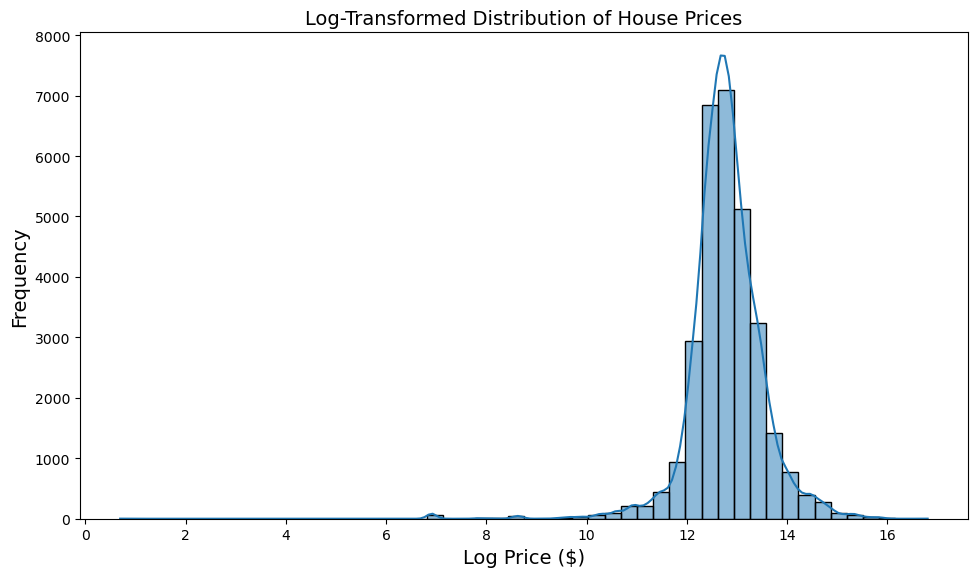

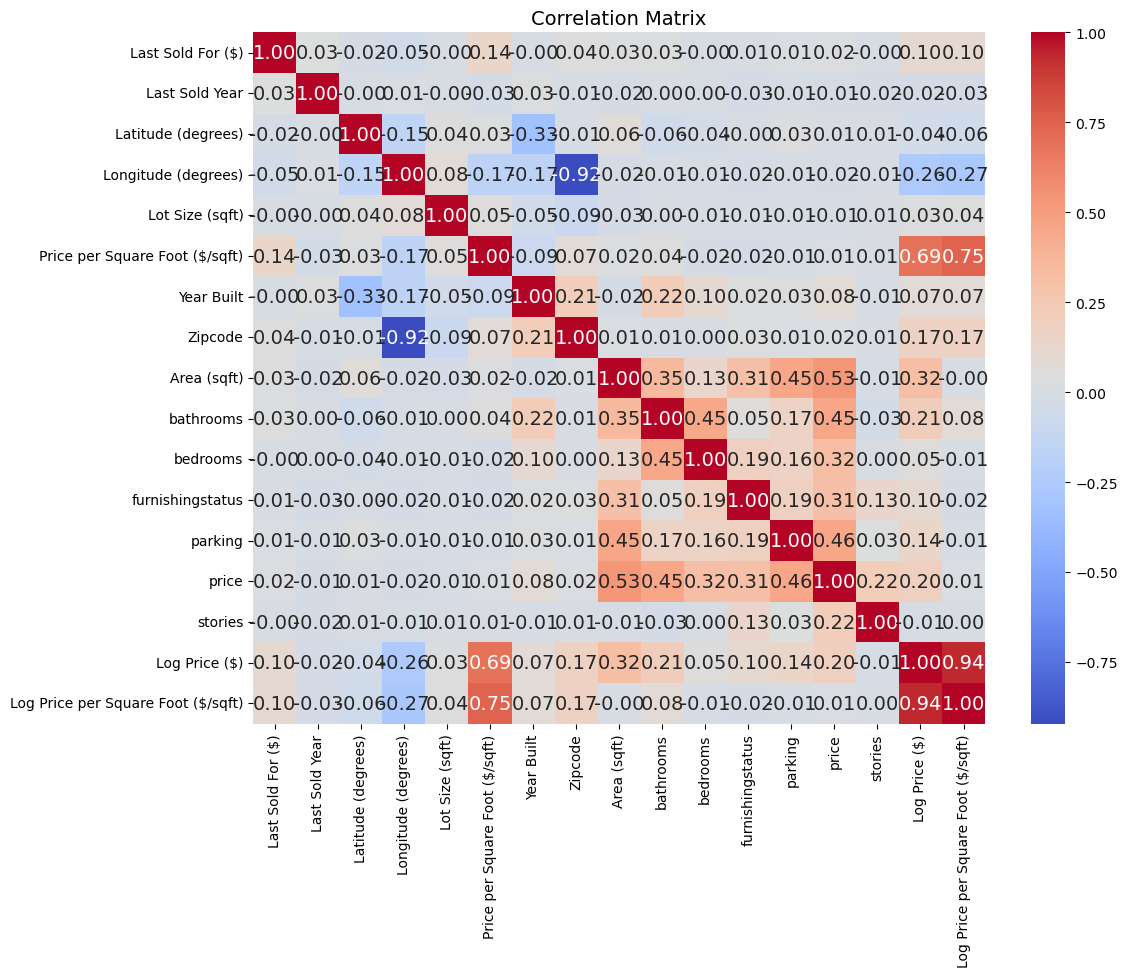

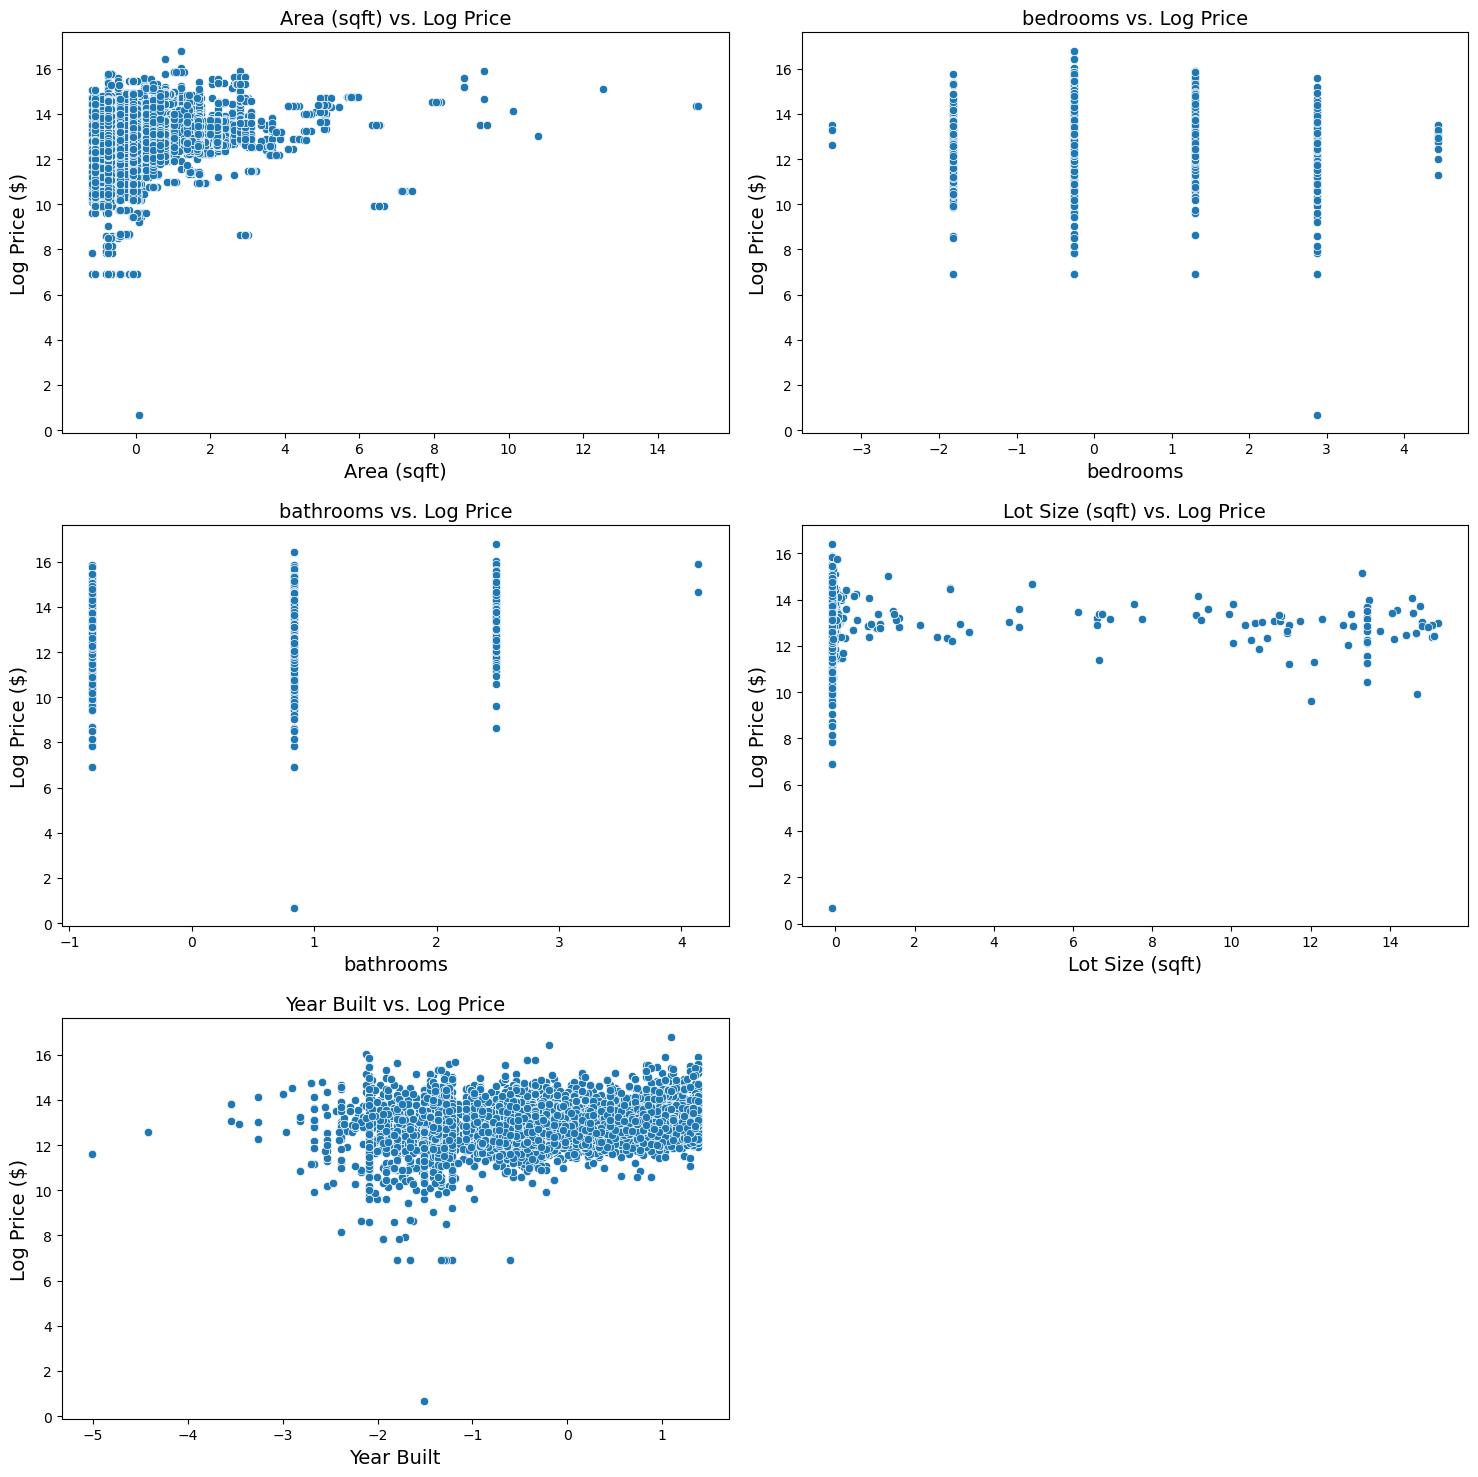

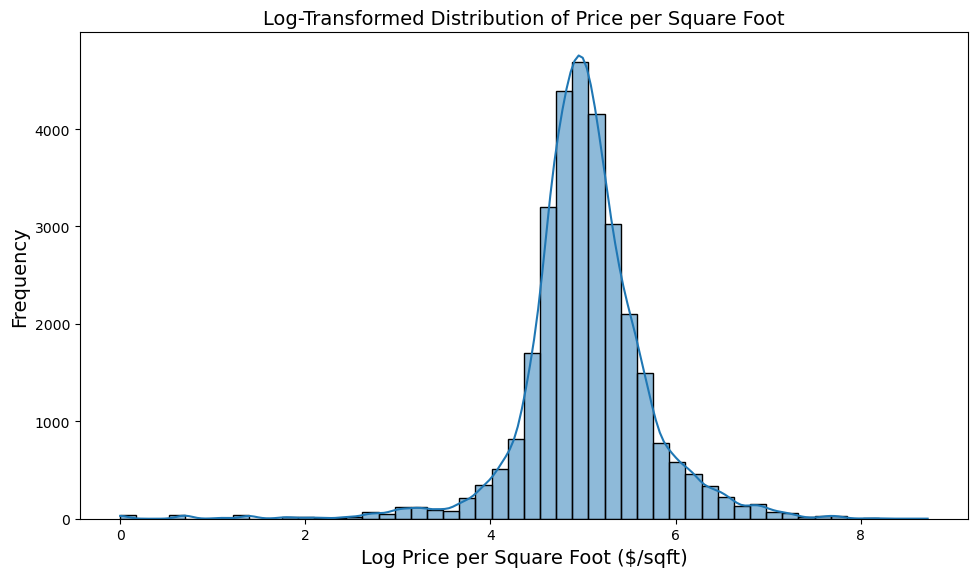

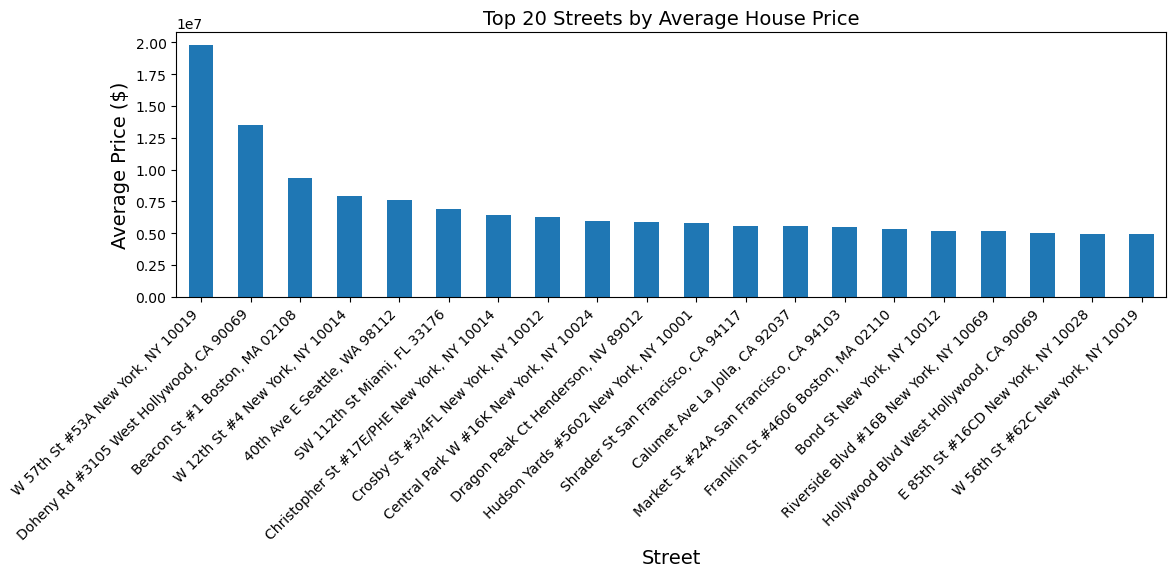

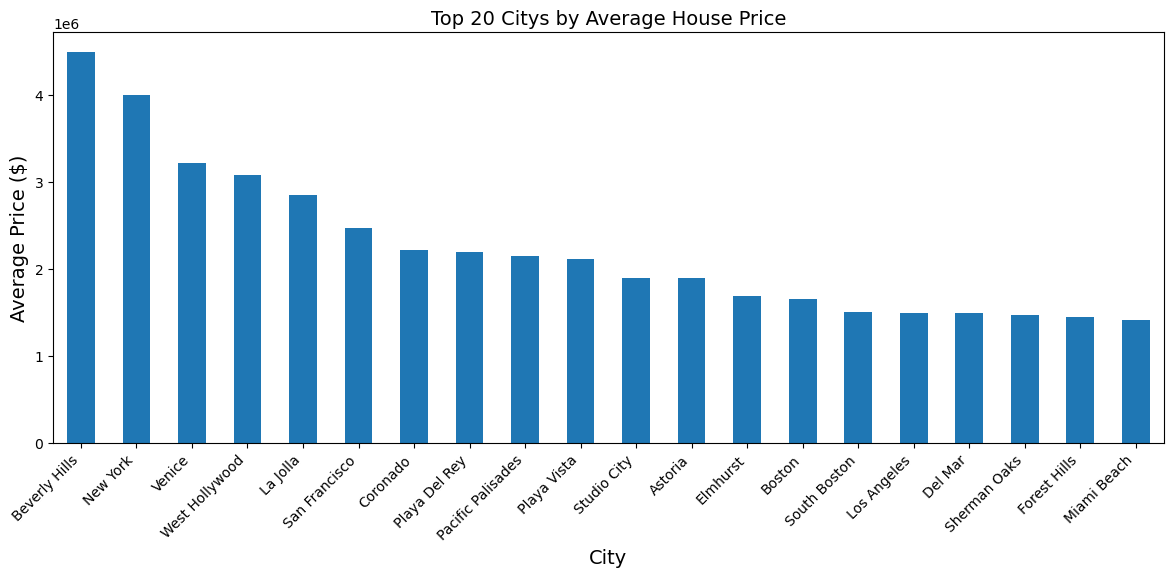

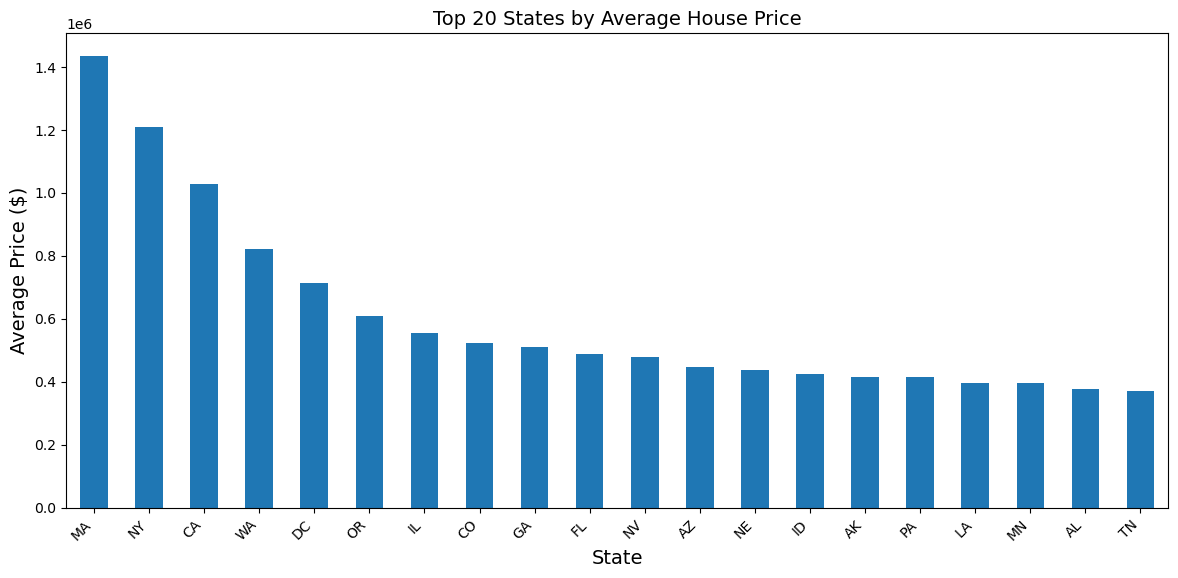

EDA completed successfully.


In [3]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Exploratory Data Analysis Class
class ExploratoryDataAnalysis:
    def __init__(self, df):
        """
        Initialize the EDA with a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame to perform EDA on.
        """
        self.df = df.copy()
        self.numeric_features = ['Area (sqft)', 'bedrooms', 'bathrooms', 'Lot Size (sqft)', 'Year Built']
        self.high_cardinality_cols = ['Price per Square Foot ($/sqft)', 'Address', 'City', 'State']
        self.output_folder = r"E:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\main task\Visualisation Outputs\Basic EDA Plots"
        os.makedirs(self.output_folder, exist_ok=True)

    def check_column_exists(self, column_name):
        """
        Check if a column exists in the DataFrame.

        Parameters:
        column_name (str): The name of the column to check.

        Returns:
        bool: True if the column exists, False otherwise.
        """
        if column_name not in self.df.columns:
            print(f"Error: '{column_name}' column not found in the dataframe.")
            return False
        return True

    def clean_data(self):
        """
        Clean the DataFrame for analysis.

        - Convert 'Price ($)' to numeric, handling 'Contact For Estimate'.
        - Ensure all numeric features are converted to numeric data types.
        - Apply log transformations to 'Price ($)' and 'Price per Square Foot ($/sqft)'.
        """
        # Clean 'Price ($)' column
        self.clean_price_column()

        # Convert numeric features to appropriate data types
        self.convert_numeric_features()

        # Log transform 'Price ($)'
        if self.check_column_exists('Price ($)'):
            self.df['Log Price ($)'] = np.log1p(self.df['Price ($)'])

        # Log transform 'Price per Square Foot ($/sqft)'
        if self.check_column_exists('Price per Square Foot ($/sqft)'):
            self.df['Log Price per Square Foot ($/sqft)'] = np.log1p(self.df['Price per Square Foot ($/sqft)'])

    def clean_price_column(self):
        """Convert 'Price ($)' to numeric, handling special cases."""
        if self.check_column_exists('Price ($)'):
            self.df['Price ($)'] = self.df['Price ($)'].replace('Contact For Estimate', np.nan)
            self.df['Price ($)'] = pd.to_numeric(self.df['Price ($)'], errors='coerce')

    def convert_numeric_features(self):
        """Ensure all specified numeric features are converted to numeric data types."""
        for feature in self.numeric_features:
            if self.check_column_exists(feature):
                self.df[feature] = pd.to_numeric(self.df[feature], errors='coerce')

    def standardize_numeric_data(self):
        """Standardize numeric features for K-Means clustering."""
        scaler = StandardScaler()
        valid_features = [feature for feature in self.numeric_features if self.check_column_exists(feature)]
        self.df[valid_features] = scaler.fit_transform(self.df[valid_features])

    def plot_distribution(self, column_name, title, xlabel):
        """
        Plot the distribution of a given numeric column.

        Parameters:
        column_name (str): The name of the column to plot.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        """
        if self.check_column_exists(column_name):
            plt.figure(figsize=(10, 6))
            sns.histplot(self.df[column_name].dropna(), bins=50, kde=True)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, f"{title.replace(' ', '_')}.png"))
            plt.show()
            plt.close()

    def plot_correlation_matrix(self):
        """
        Plot the correlation matrix for numeric features.
        """
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != 'Price ($)']
        if len(numeric_cols) > 1:
            plt.figure(figsize=(12, 10))
            corr_matrix = self.df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Correlation_Matrix.png"))
            plt.show()
            plt.close()
        else:
            print("Not enough numeric columns to plot a correlation matrix.")

    def plot_scatter_plots(self):
        """
        Generate scatter plots for each numeric feature against Log Price.
        """
        if self.check_column_exists('Log Price ($)'):
            valid_features = [feature for feature in self.numeric_features if self.check_column_exists(feature)]
            num_plots = len(valid_features)
            if num_plots == 0:
                print("No valid numeric features available for plotting.")
                return
            rows = (num_plots + 1) // 2
            fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
            axes = axes.flatten()
            for idx, feature in enumerate(valid_features):
                sns.scatterplot(
                    data=self.df,
                    x=feature,
                    y='Log Price ($)',
                    ax=axes[idx]
                )
                axes[idx].set_title(f'{feature} vs. Log Price')
                axes[idx].set_xlabel(feature)
                axes[idx].set_ylabel('Log Price ($)')
            # Remove any unused subplots
            for idx in range(num_plots, len(axes)):
                fig.delaxes(axes[idx])
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Scatter_Plots.png"))
            plt.show()
            plt.close()

    def plot_top_categories(self, category_col, value_col, top_n, title):
        plt.figure(figsize=(12, 6))
        avg_values = self.df.groupby(category_col)[value_col].mean().nlargest(top_n)
        avg_values.plot(kind='bar')
        plt.title(title)
        plt.xlabel(category_col)
        plt.ylabel(f'Average {value_col}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_folder, f"{title.replace(' ', '_')}.png"))
        plt.show()
        plt.close()

    def plot_top_streets(self):
        """
        Plot top 20 streets by average house price.
        """
        if self.check_column_exists('Address') and self.check_column_exists('Price ($)'):
            # Extract street names from addresses
            self.df['Street'] = self.df['Address'].apply(lambda x: ' '.join(str(x).split()[1:]))
            
            # Calculate average price for each street
            street_prices = self.df.groupby('Street')['Price ($)'].mean()
            
            # Get top 20 streets by average price
            top_streets = street_prices.nlargest(20)
            
            plt.figure(figsize=(12, 6))
            top_streets.plot(kind='bar')
            plt.title('Top 20 Streets by Average House Price')
            plt.xlabel('Street')
            plt.ylabel('Average Price ($)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Top_20_Streets_by_Average_Price.png"))
            plt.show()
            plt.close()
        else:
            print("Required columns for street analysis are not available.")

    def handle_high_cardinality_features(self):
        """
        Visualize high cardinality features including 'Address'.
        """
        for col in self.high_cardinality_cols:
            if self.check_column_exists(col):
                if col in ['State', 'City']:
                    self.plot_top_categories(col, 'Price ($)', 20, f'Top 20 {col}s by Average House Price')
                elif col == 'Price per Square Foot ($/sqft)':
                    self.plot_distribution(
                        column_name='Log Price per Square Foot ($/sqft)',
                        title='Log-Transformed Distribution of Price per Square Foot',
                        xlabel='Log Price per Square Foot ($/sqft)'
                    )
                elif col == 'Address':
                    self.plot_top_streets()

    def perform_eda(self):
        """
        Execute the complete EDA process:
        - Clean data
        - Standardize data
        - Plot distributions
        - Plot correlation matrix
        - Plot scatter plots
        - Handle high cardinality features
        """
        print("Starting EDA...")
        self.clean_data()
        print("Data cleaned successfully.")

        # Standardize data for further analysis
        self.standardize_numeric_data()
        print("Data standardized successfully.")

        # Plot distributions
        self.plot_distribution('Log Price ($)', 'Log-Transformed Distribution of House Prices', 'Log Price ($)')

        # Plot correlation matrix
        self.plot_correlation_matrix()

        # Plot scatter plots
        self.plot_scatter_plots()

        # Handle high cardinality features
        self.handle_high_cardinality_features()
        print("EDA completed successfully.")

# Main execution
def main():
    file_path = r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv"

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(file_path)
            if df.empty:
                print("Error: The DataFrame is empty. Unable to perform EDA.")
            else:
                print(f"Data loaded successfully. Shape: {df.shape}")
                eda = ExploratoryDataAnalysis(df)
                eda.perform_eda()
        except Exception as e:
            print(f"An error occurred during EDA: {str(e)}")

if __name__ == "__main__":
    main()

---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Advanced Exploratory Data Analysis (EDA)</span>
##### This section performs an advanced EDA on the cleaned dataset:

##### <span style="color: #1E90FF;">Categorical Variable Analysis</span>
##### - Generate box plots for top categories
##### - Visualize price distributions across categorical features

##### <span style="color: #1E90FF;">Price per Square Foot Analysis</span>
##### - Clean and transform data, handle outliers
##### - Create histograms for original and log-transformed values

##### <span style="color: #1E90FF;">Text Data Visualization</span>
##### - Generate word clouds or plot top 20 common words

##### <span style="color: #1E90FF;">Advanced Visualization Techniques</span>
##### - Use seaborn for enhanced graphics
##### - Implement multi-plot figures for feature comparisons

##### <span style="color: #1E90FF;">Data Integrity and Error Handling</span>
##### - Check column existence, handle missing values
##### - Incorporate robust error handling

##### <span style="color: #1E90FF;">Performance and Scalability</span>
##### - Efficient data handling for large datasets
##### - Appropriate plot sizes and layouts

##### <span style="color: #1E90FF;">Output Management</span>
##### - Save plots in dedicated folder
##### - Provide informative console outputs

##### Insights from this analysis are saved in Weekly Tasks\Visualisation Outputs\Insights\Task 2 EDA Insights.md

Data loaded successfully. Shape: (30683, 25)
Starting EDA...
Cleaning data...
Data cleaned successfully.
Data standardized successfully.
Plotting box plots for categorical variables...


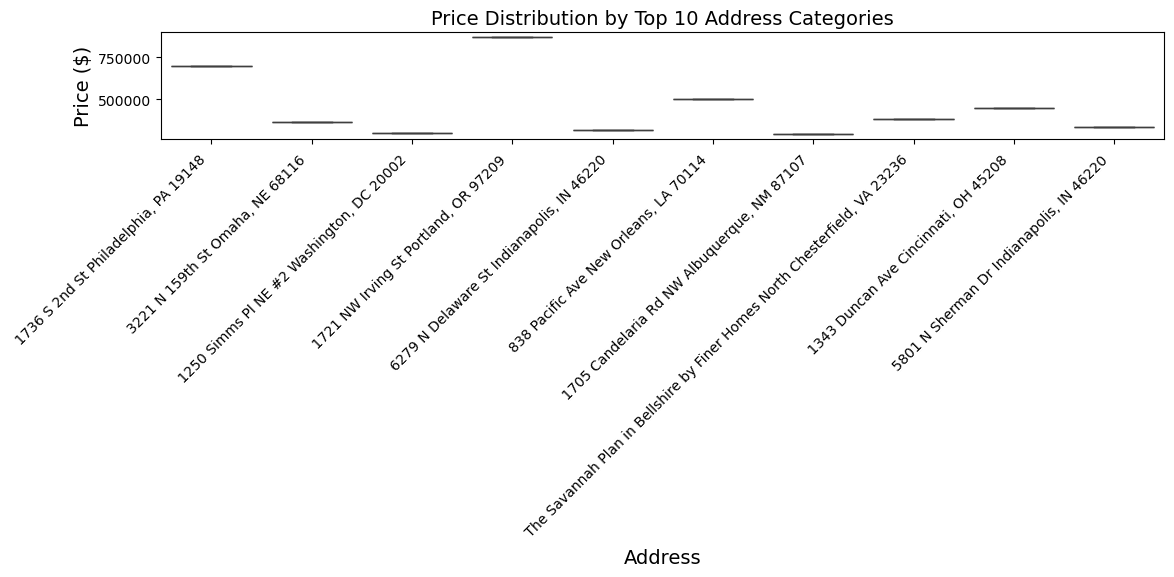

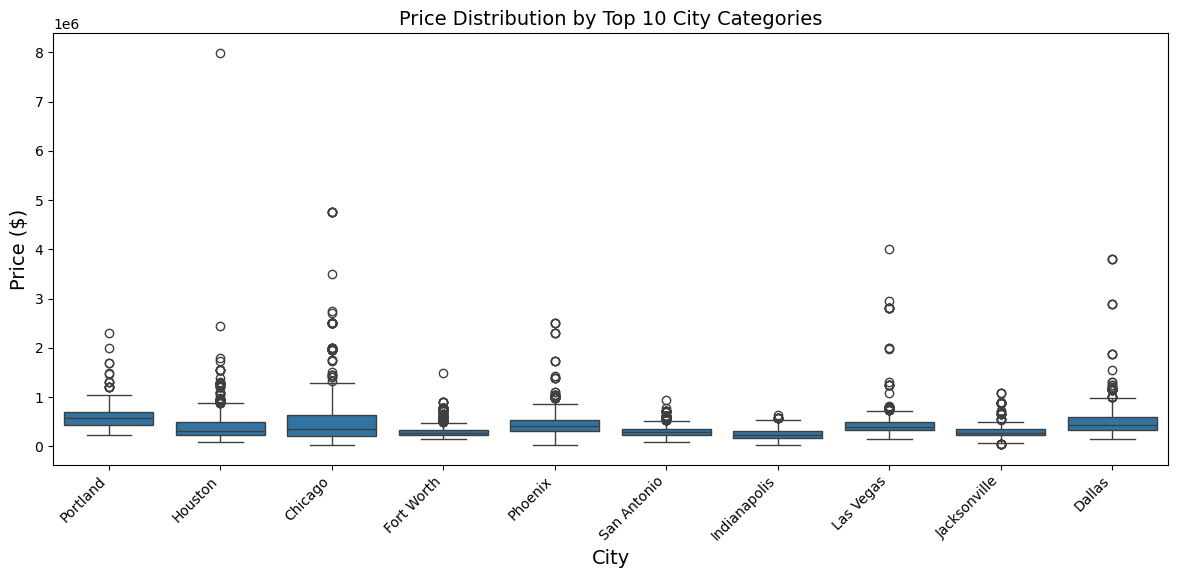

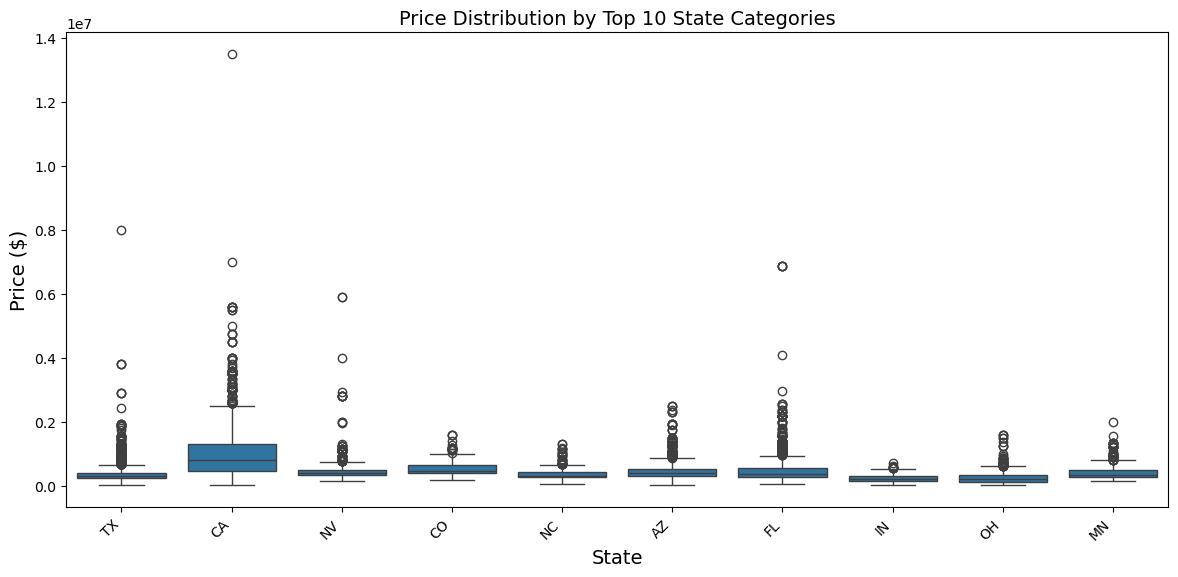

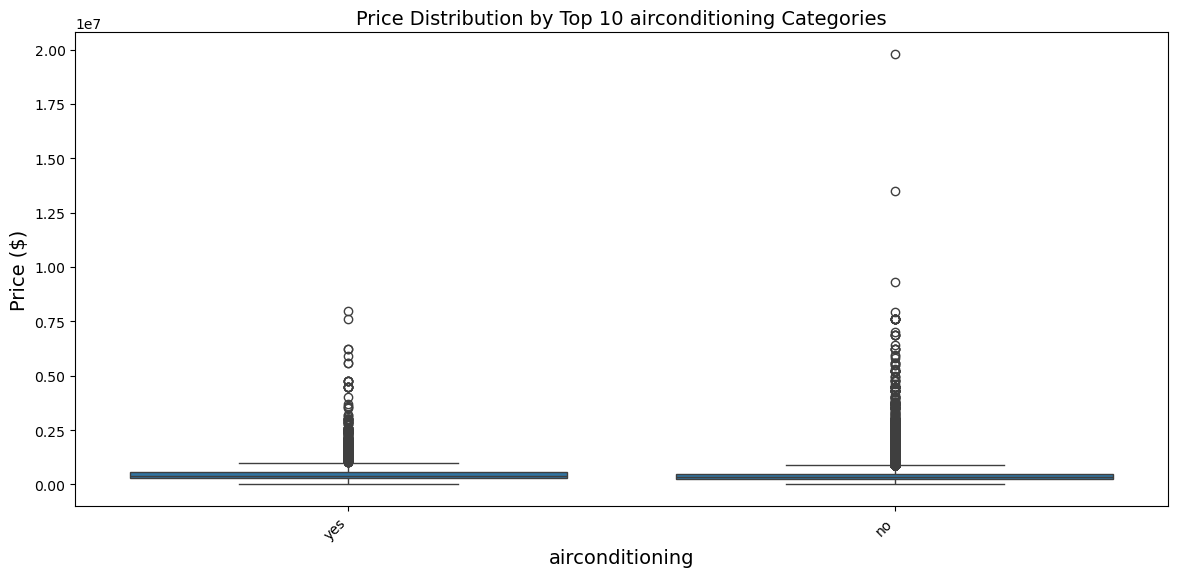

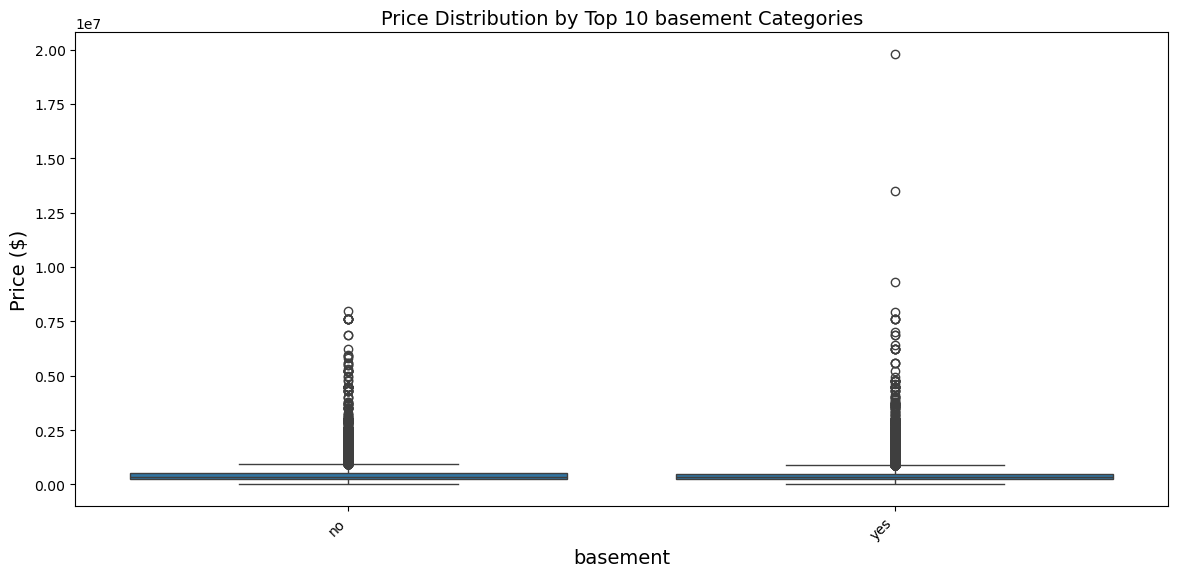

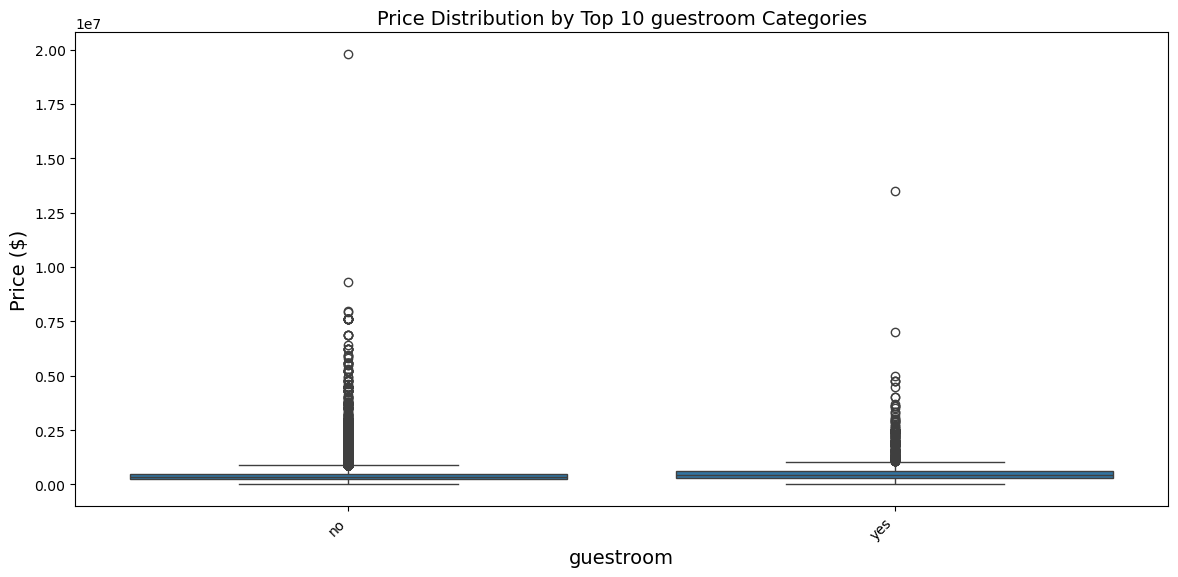

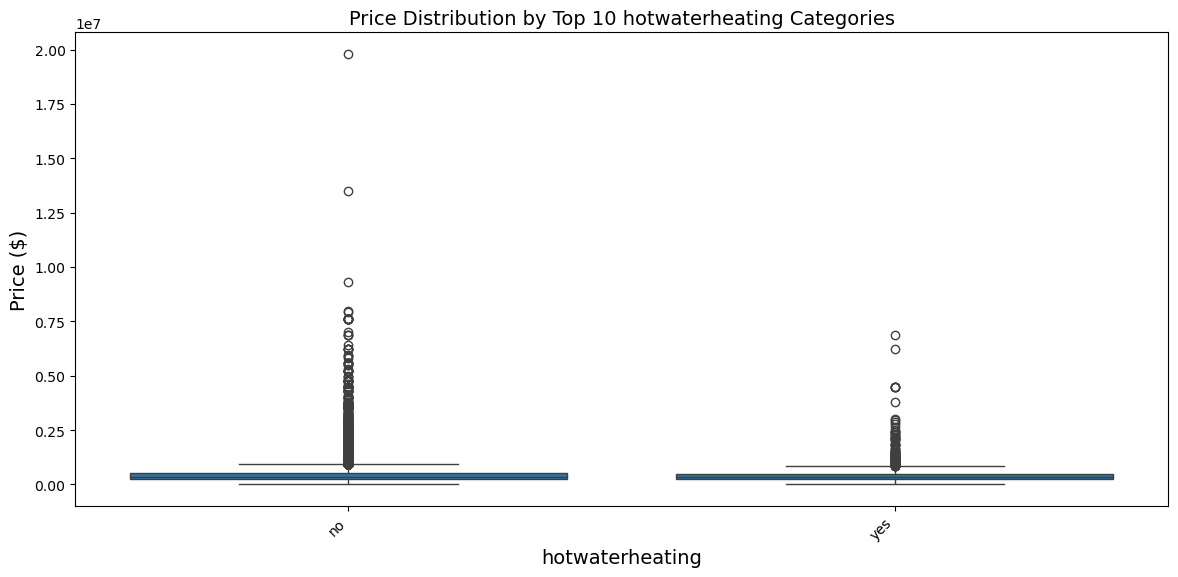

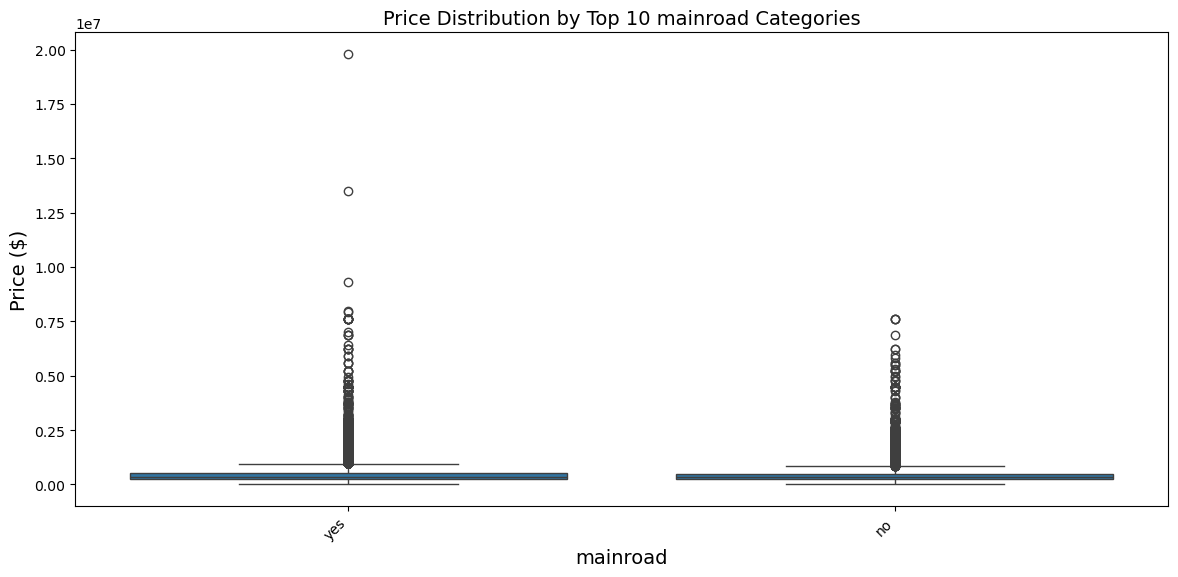

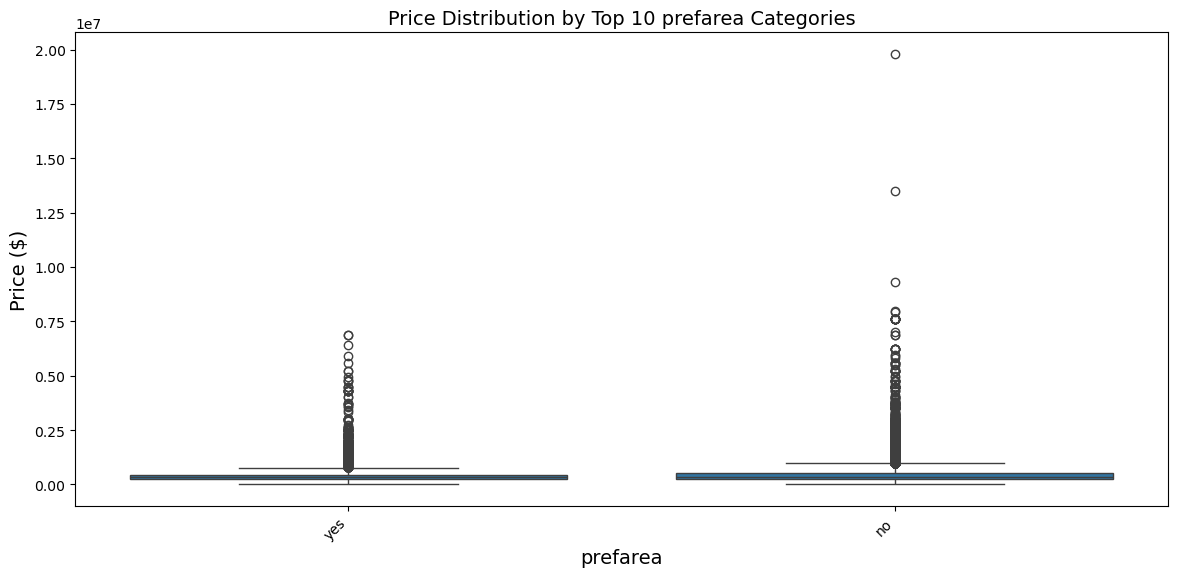

Handling 'Price per Square Foot ($/sqft)'...


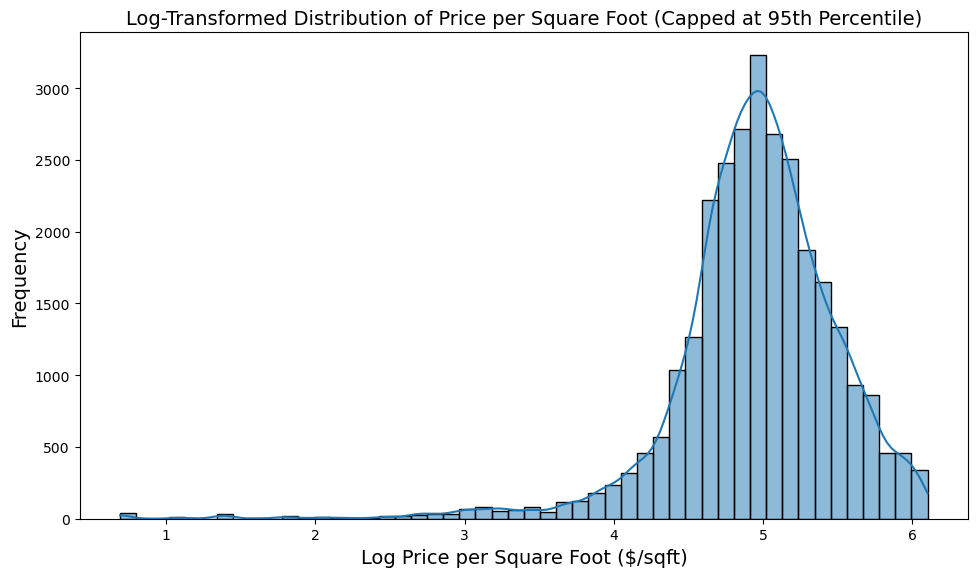

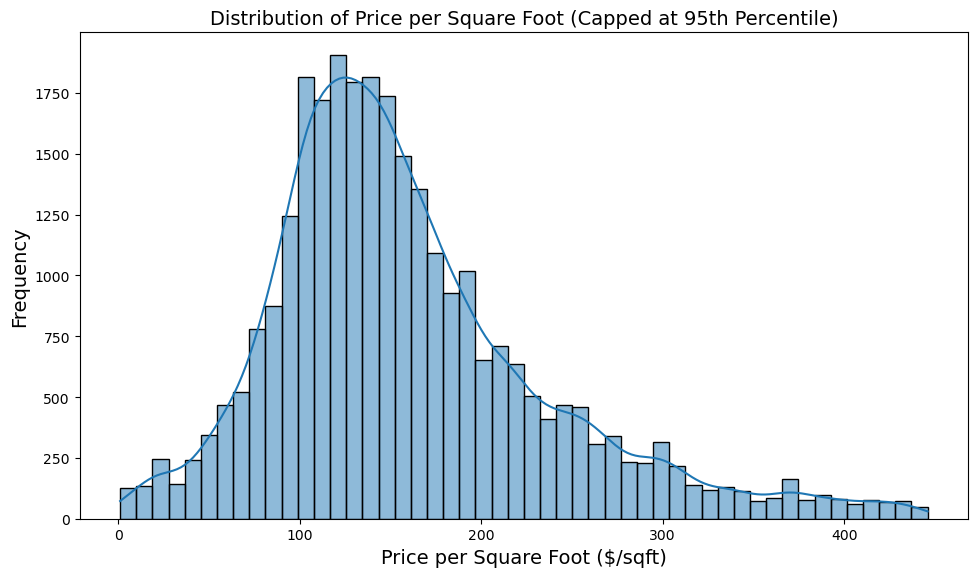

Generating word cloud for Address...


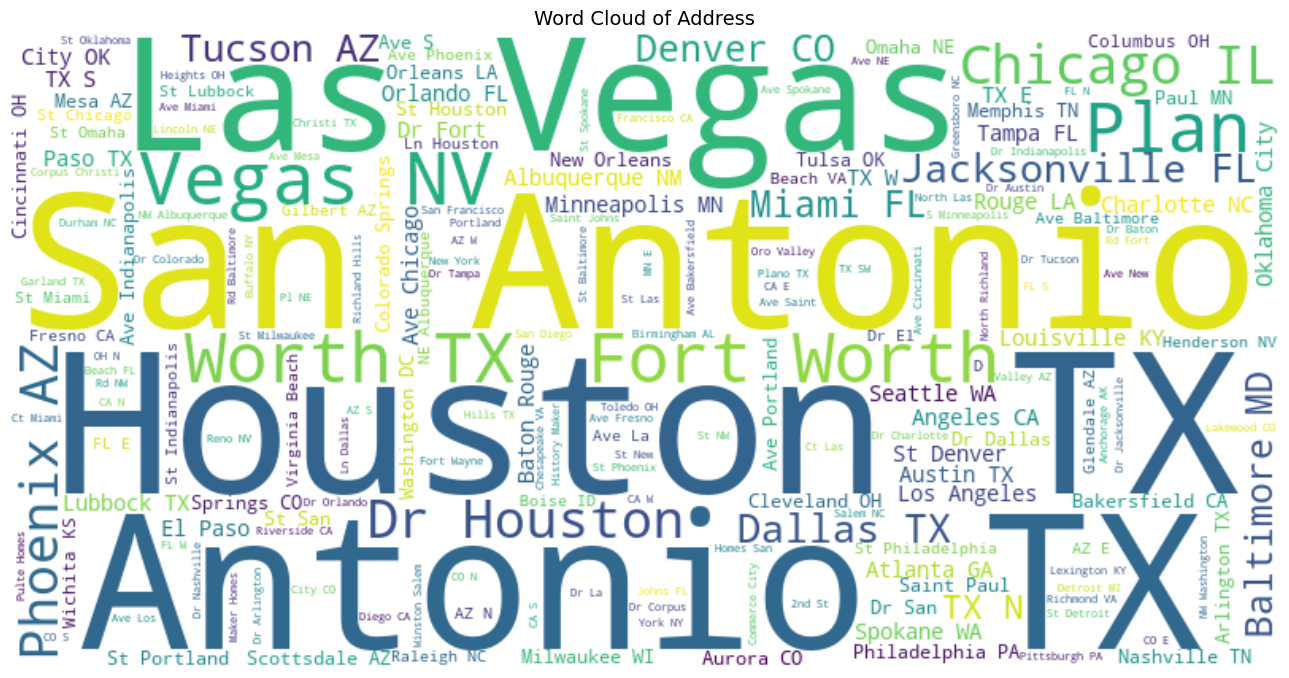

Plotting pair plot for numerical features...


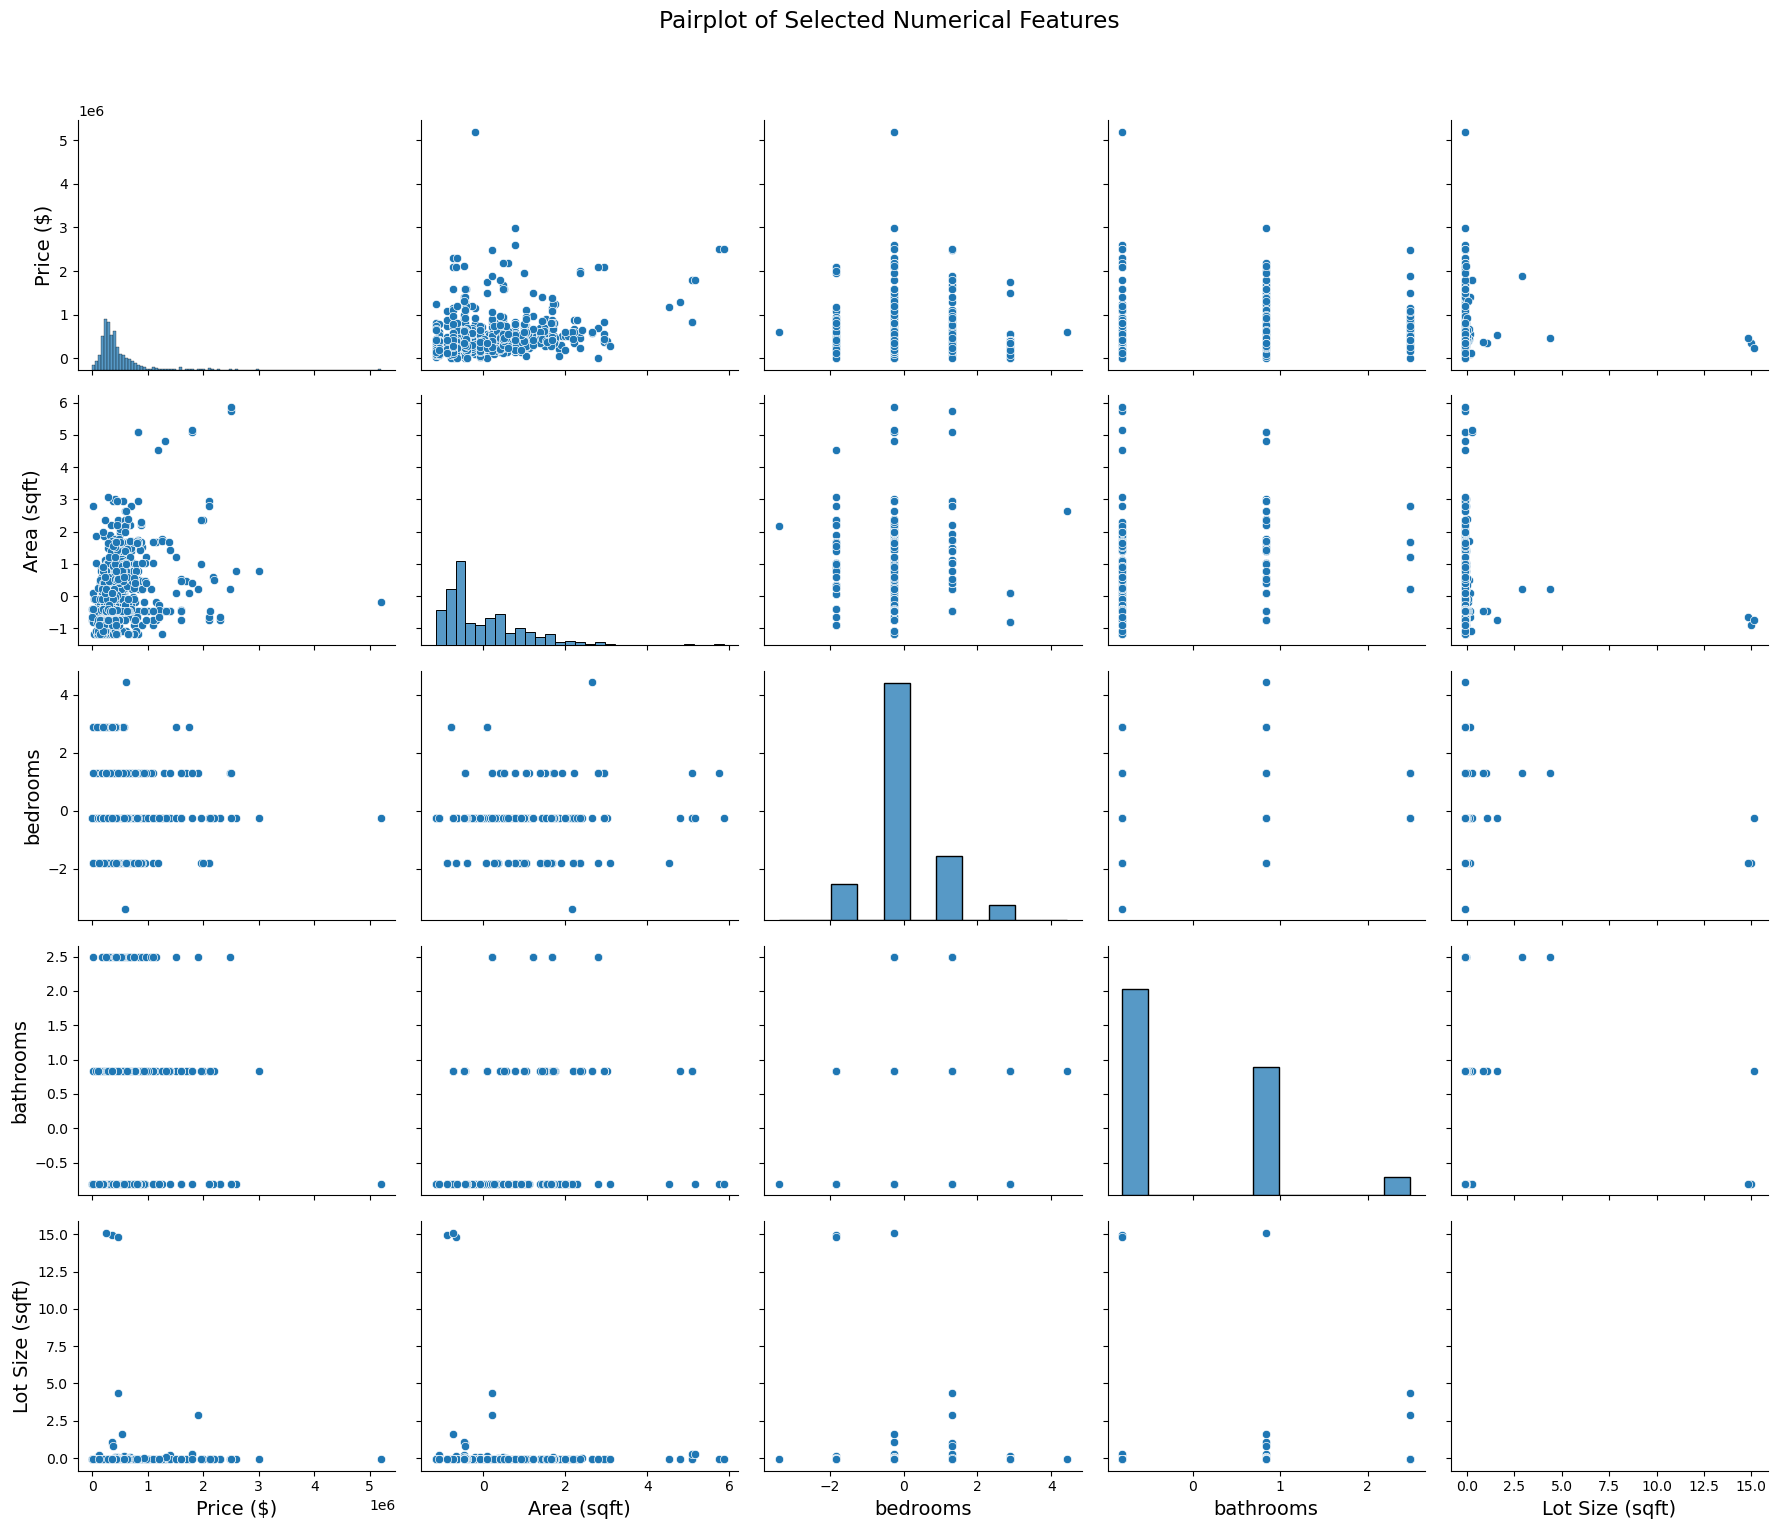

EDA completed successfully.


In [4]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.preprocessing import StandardScaler

# Import WordCloud if available
try:
    from wordcloud import WordCloud
except ImportError:
    WordCloud = None

# Advanced Exploratory Data Analysis Class
class ExploratoryDataAnalysis:
    def __init__(self, df):
        """
        Initialize the EDA with a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame to perform EDA on.
        """
        self.df = df.copy()
        # Updated column names to match your DataFrame
        self.numeric_features = ['Area (sqft)', 'bedrooms', 'bathrooms', 'Lot Size (sqft)', 'Year Built']
        self.high_cardinality_cols = ['Price per Square Foot ($/sqft)', 'City', 'State']
        self.categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        self.output_folder = r"E:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\main task\Visualisation Outputs\Advanced EDA Plots"
        os.makedirs(self.output_folder, exist_ok=True)

    def check_column_exists(self, column_name):
        """
        Check if a column exists in the DataFrame.

        Parameters:
        column_name (str): The name of the column to check.

        Returns:
        bool: True if the column exists, False otherwise.
        """
        if column_name not in self.df.columns:
            print(f"Error: '{column_name}' column not found in the dataframe.")
            return False
        return True

    def clean_data(self):
        """
        Clean the DataFrame for analysis.

        - Convert 'Price ($)' to numeric, handling 'Contact For Estimate'.
        - Convert 'Lot Size (sqft)' from acres to sqft if necessary.
        - Ensure all numeric features are converted to numeric data types.
        - Log transform 'Price ($)'.
        """
        print("Cleaning data...")
        # Clean 'Price ($)' column
        self.clean_price_column()

        # Clean 'Lot Size (sqft)' column
        self.clean_lot_size_column()

        # Convert numeric features to appropriate data types
        self.convert_numeric_features()

        # Log transform 'Price ($)'
        if self.check_column_exists('Price ($)'):
            self.df['Log Price ($)'] = np.log1p(self.df['Price ($)'])

    def clean_price_column(self):
        """Convert 'Price ($)' to numeric, handling special cases."""
        if self.check_column_exists('Price ($)'):
            self.df['Price ($)'] = self.df['Price ($)'].replace('Contact For Estimate', np.nan)
            self.df['Price ($)'] = pd.to_numeric(self.df['Price ($)'], errors='coerce')

    def clean_lot_size_column(self):
        """Clean and convert 'Lot Size (sqft)' to numeric values in sqft."""
        if self.check_column_exists('Lot Size (sqft)'):
            # Apply conversion to each value in 'Lot Size (sqft)'
            self.df['Lot Size (sqft)'] = self.df['Lot Size (sqft)'].apply(self.convert_lot_size)
            # Convert the cleaned values to numeric
            self.df['Lot Size (sqft)'] = pd.to_numeric(self.df['Lot Size (sqft)'], errors='coerce')

    def convert_numeric_features(self):
        """Ensure all specified numeric features are converted to numeric data types."""
        for feature in self.numeric_features:
            if self.check_column_exists(feature):
                self.df[feature] = pd.to_numeric(self.df[feature], errors='coerce')

    @staticmethod
    def convert_lot_size(value):
        """
        Convert 'Lot Size (sqft)' from acres to sqft if applicable.

        Parameters:
        value: The value to convert.

        Returns:
        float: The converted lot size in sqft, or NaN if conversion fails.
        """
        try:
            if pd.isna(value):
                return np.nan
            value_str = str(value).strip().lower()
            if 'acres' in value_str:
                # Extract the numeric part and convert acres to sqft
                number = float(value_str.replace('acres', '').strip())
                return number * 43560
            else:
                # Remove commas and convert to float
                return float(value_str.replace(',', ''))
        except (ValueError, TypeError):
            return np.nan

    def standardize_numeric_data(self):
        """Standardize numeric features for analysis."""
        scaler = StandardScaler()
        valid_features = [feature for feature in self.numeric_features if self.check_column_exists(feature)]
        self.df[valid_features] = scaler.fit_transform(self.df[valid_features])

    def plot_categorical_boxplots(self):
        """
        Plot box plots for top categories in categorical variables.
        """
        print("Plotting box plots for categorical variables...")
        categorical_cols = [col for col in self.categorical_cols if col != 'Price ($)']
        for col in categorical_cols:
            if self.check_column_exists(col):
                # Get top 10 categories by frequency
                top_categories = self.df[col].value_counts().nlargest(10).index
                df_top = self.df[self.df[col].isin(top_categories)]
                if not df_top.empty and 'Price ($)' in df_top.columns:
                    plt.figure(figsize=(12, 6))
                    sns.boxplot(x=col, y='Price ($)', data=df_top)
                    plt.title(f'Price Distribution by Top 10 {col} Categories')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    filename = f'boxplot_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()

    def handle_price_per_sqft(self):
        """
        Clean, transform, and plot 'Price per Square Foot ($/sqft)' data.
        """
        col = 'Price per Square Foot ($/sqft)'
        if self.check_column_exists(col):
            print("Handling 'Price per Square Foot ($/sqft)'...")
            # Convert to numeric
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
            # Drop NaN values and filter out non-positive values
            df_clean = self.df.dropna(subset=[col]).copy()
            df_clean = df_clean[df_clean[col] > 0]
            if not df_clean.empty:
                # Cap outliers at the 95th percentile
                price_cap = df_clean[col].quantile(0.95)
                df_capped = df_clean[df_clean[col] <= price_cap].copy()
                # Apply logarithmic transformation
                df_capped['Log Price per Square Foot'] = np.log1p(df_capped[col])
                # Plot the log-transformed, capped distribution
                plt.figure(figsize=(10, 6))
                sns.histplot(df_capped['Log Price per Square Foot'], bins=50, kde=True)
                plt.title('Log-Transformed Distribution of Price per Square Foot (Capped at 95th Percentile)')
                plt.xlabel('Log Price per Square Foot ($/sqft)')
                plt.ylabel('Frequency')
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_folder, 'log_transformed_price_per_sqft.png'))
                plt.show()  # Display the plot
                plt.close()

                # Plot the original distribution (before log transformation)
                plt.figure(figsize=(10, 6))
                sns.histplot(df_capped[col], bins=50, kde=True)
                plt.title('Distribution of Price per Square Foot (Capped at 95th Percentile)')
                plt.xlabel('Price per Square Foot ($/sqft)')
                plt.ylabel('Frequency')
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_folder, 'original_price_per_sqft.png'))
                plt.show()  # Display the plot
                plt.close()
            else:
                print("No valid data to plot for 'Price per Square Foot ($/sqft)'.")

    def plot_wordclouds(self):
        """
        Generate word clouds for address columns, or plot top words.
        """
        for col in ['Address']:
            if self.check_column_exists(col):
                print(f"Generating word cloud for {col}...")
                if WordCloud:
                    # Generate word cloud
                    text = ' '.join(self.df[col].dropna())
                    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
                    plt.figure(figsize=(15, 7))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Word Cloud of {col}')
                    plt.tight_layout()
                    filename = f'wordcloud_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()
                else:
                    # Alternative visualization: Top 20 most common words
                    words = ' '.join(self.df[col].dropna()).split()
                    word_counts = Counter(words)
                    common_words = word_counts.most_common(20)
                    plt.figure(figsize=(12, 6))
                    sns.barplot(x=[word for word, _ in common_words], y=[count for _, count in common_words])
                    plt.title(f'Top 20 Most Common Words in {col}')
                    plt.xlabel('Words')
                    plt.ylabel('Count')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    filename = f'top_words_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()

    def plot_pairs_plot(self):
        """
        Plot pair plots for selected numerical features.
        """
        print("Plotting pair plot for numerical features...")
        # Updated column names to match your DataFrame
        selected_numeric_cols = ['Price ($)', 'Area (sqft)', 'bedrooms', 'bathrooms', 'Lot Size (sqft)']
        available_numeric_cols = [col for col in selected_numeric_cols if col in self.df.columns]

        if len(available_numeric_cols) >= 2:
            # Sample data if too large
            df_numeric = self.df[available_numeric_cols].dropna()
            if df_numeric.shape[0] > 1000:
                df_sampled = df_numeric.sample(1000, random_state=42)
            else:
                df_sampled = df_numeric

            sns.pairplot(df_sampled, height=3, aspect=1.2)
            plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
            plt.tight_layout()
            filename = 'pairplot_numeric_features.png'
            plt.savefig(os.path.join(self.output_folder, filename))
            plt.show()  # Display the plot
            plt.close()
        else:
            print("Not enough numerical columns available for pair plot.")

    def perform_eda(self):
        """
        Execute the complete EDA process:
        - Clean data
        - Standardize data
        - Plot box plots for categorical variables
        - Handle 'Price per Square Foot ($/sqft)' column
        - Generate word clouds or top words for address columns
        - Plot pair plots for numerical features
        """
        print("Starting EDA...")
        self.clean_data()
        print("Data cleaned successfully.")

        # Standardize data
        self.standardize_numeric_data()
        print("Data standardized successfully.")

        # Plot box plots for categorical variables
        self.plot_categorical_boxplots()

        # Handle 'Price per Square Foot ($/sqft)'
        self.handle_price_per_sqft()

        # Generate word clouds or top words for address columns
        self.plot_wordclouds()

        # Plot pair plot for numerical features
        self.plot_pairs_plot()

        print("EDA completed successfully.")

# Main execution
def main():
    file_path = r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv"

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
        return
    
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            print("Error: The dataframe is empty. Unable to perform EDA.")
        else:
            print(f"Data loaded successfully. Shape: {df.shape}")
            eda = ExploratoryDataAnalysis(df)
            eda.perform_eda()
    except Exception as e:
        print(f"An error occurred during EDA: {str(e)}")

if __name__ == "__main__":
    main()

---------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------

### Model Building-Main

##### <span style="color: #FF0000;">Weekly Tasks 2</span>

##### Model the data to find the price based on the input features.

##### <span style="color: #1E90FF;">Model Building and Evaluation</span>
###### <a id="model-building-and-evaluation"></a>

##### This section contains the main solution for model building and evaluation.
##### If you arrived here from the link at the top of the notebook, you're in the right place!

##### To navigate back to the top of the notebook, use this link:
###### [Back to Top](#top-of-notebook)

In [9]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
df = pd.read_csv(r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv")

# Data Preparation for Clustering
def prepare_data_for_clustering(df):
    """
    Prepare the data for clustering by performing feature engineering,
    handling missing values, and standardizing numerical features.
    """
    # Update column names to match your DataFrame
    required_cols = ['Area (sqft)', 'bedrooms', 'bathrooms', 'Lot Size (sqft)', 'Year Built', 'Price ($)']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Feature Engineering
    df = df.copy()
    df['Age'] = 2023 - df['Year Built']
    df['Beds_Bath'] = df['bedrooms'] * df['bathrooms']
    df['Area^2'] = df['Area (sqft)'] ** 2

    # Select features for clustering
    features = ['Area (sqft)', 'bedrooms', 'bathrooms', 'Lot Size (sqft)', 'Age', 'Beds_Bath', 'Area^2']
    X = df[features].copy()

    # Convert columns to numeric, coercing errors to NaN
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

    # Handle missing values by replacing with the median
    X = X.fillna(X.median())

    # Standardize the features (important for clustering)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("Data prepared for clustering.")
    return X_scaled, df

# K-Means Clustering
def perform_kmeans_clustering(X_scaled, df, n_clusters=5):
    """
    Perform K-Means clustering on the standardized data and return the clustering labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Add cluster centres to the dataframe for visualization
    cluster_centers = kmeans.cluster_centers_
    df['Cluster Centre Price'] = [cluster_centers[cluster][0] for cluster in df['Cluster']]

    print(f"K-Means clustering performed with {n_clusters} clusters.")
    return df, kmeans

# Visualization: Scatter plots of clusters
def visualize_clusters(df, output_folder):
    """
    Visualize clusters using scatter plots and highlight cluster centers.
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Area (sqft)', y='Price ($)', hue='Cluster', data=df, palette='viridis', alpha=0.6)
    plt.title('K-Means Clustering: Area (sqft) vs Price ($)')
    plt.xlabel('Area (sqft)')
    plt.ylabel('Price ($)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'cluster_scatterplot.png'))
    plt.close()

    # Visualize cluster centres on top of the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Area (sqft)', y='Price ($)', hue='Cluster', data=df, palette='viridis', alpha=0.6)
    plt.scatter(df.groupby('Cluster')['Area (sqft)'].mean(), 
                df.groupby('Cluster')['Price ($)'].mean(), 
                color='red', marker='x', s=200, label='Cluster Centers')
    plt.title('Clusters with Cluster Centres')
    plt.xlabel('Area (sqft)')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'cluster_centre_visualization.png'))
    plt.close()

    print("Cluster visualizations saved successfully.")

# Main execution
def main():
    df_path = r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv"
    output_folder = r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\Visualisation Outputs"

    if not os.path.exists(df_path):
        print(f"Error: The file '{df_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(df_path)
            if df.empty:
                print("Error: The DataFrame is empty. Unable to perform clustering.")
            else:
                # Prepare data for clustering
                X_scaled, df_prepared = prepare_data_for_clustering(df)

                # Perform K-Means clustering
                df_clustered, kmeans = perform_kmeans_clustering(X_scaled, df_prepared, n_clusters=5)

                # Visualize clusters and cluster centers
                visualize_clusters(df_clustered, output_folder)

        except Exception as e:
            print(f"An error occurred during clustering: {str(e)}")

if __name__ == "__main__":
    main()

Data prepared for clustering.
K-Means clustering performed with 5 clusters.
Cluster visualizations saved successfully.


---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Model Evaluation:</span>

##### We will now proceed with evaluating our clustering model. This evaluation will include:

##### <span style="color: #1E90FF;">1. **Inertia (Within-Cluster Sum of Squares)**:</span>
######    - Measures how well the clusters fit the data

##### <span style="color: #1E90FF;">2. **Silhouette Score:**</span>
######    - Indicates how well-separated the clusters are

##### <span style="color: #1E90FF;">3. **Cluster Distribution:**</span>
######    - Analyzes the balance of data points across clusters

##### <span style="color: #1E90FF;">4. **Centroid Analysis:**</span>
######    - Examines the characteristics of each cluster's center

##### The results of this evaluation will provide insights into the quality and interpretability of our clustering model.



Data prepared for clustering.
K-Means clustering performed with 5 clusters.
Inertia: 105650.8624
Silhouette Score: 0.2987
Cluster Distribution:
Cluster
0    11453
2     7083
1     6131
3     5770
4      246
Name: count, dtype: int64
Cluster Centroids (for each feature):
   Sqr Ft (sqft)      Beds      Bath  Lot Size (sqft)       Age  Beds_Bath  \
0      -0.563457 -0.514437 -0.812060        -0.067385 -0.295049  -0.785450   
1       0.223491 -0.301982  0.788522        -0.029338 -0.390439   0.361324   
2       0.394270  1.399334  1.173972        -0.035945 -0.294757   1.486341   
3       0.166554 -0.388751 -0.683700         0.210263  1.339698  -0.666815   
4       5.395014  0.302612  0.381911        -0.030822  0.518325   0.401890   

   Sqr Ft^2  
0 -0.448421  
1  0.156849  
2  0.253503  
3  0.112174  
4  7.030899  


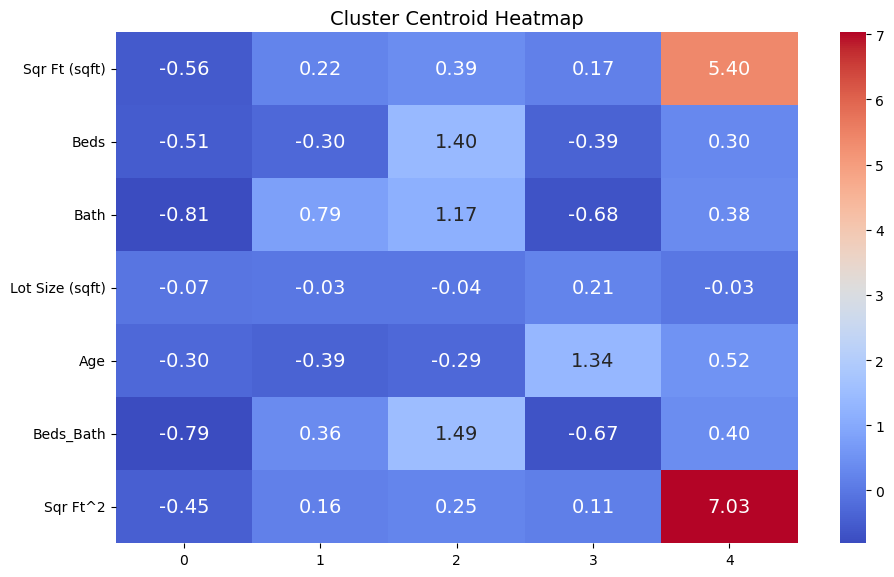

In [15]:
from sklearn.metrics import silhouette_score

def evaluate_clustering(df, X_scaled, kmeans):
    """
    Evaluate the quality of clustering using inertia and silhouette score.
    """
    # Inertia: Sum of squared distances of samples to their closest cluster center
    inertia = kmeans.inertia_
    print(f'Inertia: {inertia:.4f}')

    # Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters
    silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
    print(f'Silhouette Score: {silhouette_avg:.4f}')

    # Cluster distribution: Count the number of points in each cluster
    cluster_counts = df['Cluster'].value_counts()
    print("Cluster Distribution:")
    print(cluster_counts)

def analyze_centroids(kmeans, features):
    """
    Analyze the centroids to interpret typical values for each cluster.
    """
    centroids = kmeans.cluster_centers_
    print("Cluster Centroids (for each feature):")
    centroid_df = pd.DataFrame(centroids, columns=features)
    print(centroid_df)

    # Optional: Visualize the centroids for better interpretation
    plt.figure(figsize=(10, 6))
    sns.heatmap(centroid_df.T, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
    plt.title('Cluster Centroid Heatmap')
    plt.tight_layout()
    plt.savefig(r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\Visualisation Outputs\centroid_heatmap.png")
    plt.show()

# Main execution - after clustering
def main():
    df_path = r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv"

    if not os.path.exists(df_path):
        print(f"Error: The file '{df_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(df_path)
            if df.empty:
                print("Error: The DataFrame is empty. Unable to perform clustering.")
            else:
                # Prepare data for clustering
                X_scaled, df_prepared = prepare_data_for_clustering(df)

                # Perform K-Means clustering
                df_clustered, kmeans = perform_kmeans_clustering(X_scaled, df_prepared, n_clusters=5)

                # Evaluate the clustering quality
                evaluate_clustering(df_clustered, X_scaled, kmeans)

                # Analyze cluster centroids
                analyze_centroids(kmeans, ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Age', 'Beds_Bath', 'Sqr Ft^2'])

        except Exception as e:
            print(f"An error occurred during clustering: {str(e)}")

if __name__ == "__main__":
    main()


---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Clustering Results Analysis:</span>

##### <span style="color: #FF0000;">Overall, the cluster centroid heatmap and evaluation metrics provide a good starting point for understanding the clustering results, but suggest room for improvement in cluster separation and balance.</span>

##### <span style="color: #1E90FF;">1. **Inertia (Within-Cluster Sum of Squares)**:</span>
######    - Inertia value: 105650.8624
######    - Indicates how well clusters fit the data
######    - Lower inertia suggests better clustering
######    - Need to balance with number of clusters

##### <span style="color: #1E90FF;">2. **Silhouette Score (0.2987)**:</span>
######    - Score closer to 1 indicates well-separated clusters
######    - 0.2987 suggests clusters are not particularly well-separated
######    - May indicate need for more clusters or different clustering method

##### <span style="color: #1E90FF;">3. **Cluster Distribution**:</span>
######    - Cluster 0: 11,453 data points
######    - Cluster 4: 246 data points
######    - Imbalance suggests some clusters may not represent data well
######    - Some clusters might be overly broad

##### <span style="color: #1E90FF;">4. **Centroid Analysis**:</span>
######    - Provides insight into characteristics of each cluster
######    - Cluster 4: Significantly larger values for Sqr Ft (sqft) and Sqr Ft^2
######    - Likely represents larger, more expensive houses



---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">EDA Insights Summary:</span>

##### <span style="color: #1E90FF;">1. **Price Distribution**:</span> 
#####    - High prices in Golden Beach, Beverly Hills, Rancho Santa Fe. 
#####    - High prices in New York, Massachusetts, California. 
#####    - Large price disparity in wealthy areas. 

##### <span style="color: #1E90FF;">2. **Property Characteristics**:</span> 
#####    - More bathrooms/bedrooms = higher values. 
#####    - Larger properties usually more expensive. 
#####    - Lot size weakly correlated with price. 
#####    - Newer constructions priced higher. 

##### <span style="color: #1E90FF;">3. **Price per Square Foot**:</span> 
#####    - Consistent across categories, high-end outliers. 
#####    - Log-transforming normalizes data. 

##### <span style="color: #1E90FF;">4. **Geographical Insights**:</span> 
#####    - Negative correlation between Zipcode and Longitude. 
#####    - Common locations: Houston, Las Vegas, San Antonio. 
#####    - Frequent terms: "Plan", "Ave", "Dr", "Rd". 

##### <span style="color: #1E90FF;">5. **Data Transformation**:</span> 
#####    - Log transformation stabilizes variance. 
#####    - Log-transformed prices mostly between 10-15. 

##### <span style="color: #1E90FF;">6. **Outliers**:</span> 
#####    - Significant outliers in price distributions. 
#####    - Larger lot sizes show more price variability. 
#####    - Numerous outliers due to luxury locations/features. 

##### <span style="color: #1E90FF;">7. **Feature Relationships**:</span> 
#####    - Strong correlation between bedrooms and bathrooms. 
#####    - Weak positive relationships between price and beds/baths. 
#####    - Scatter plots reveal luxury property outliers. 

##### <span style="color: #1E90FF;">8. **Address Insights**:</span> 
#####    - Significant price variation across addresses. 
#####    - Wide price ranges in "E Dale Ln Scottsdale" and "Lenexa Plan in Parten". 

##### <span style="color: #FF0000;">Overall, EDA reveals housing market complexity, emphasizing location, property features, and luxury segments. Log transformations and outlier capping normalize data for better analysis and predictive modeling.</span>

---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Miscellaneous- Personal use and reference</span>
